In [1]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import source.selection_criteria as sc
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
import astropy.units as u

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/runburg/github/agn_lf


In [2]:
xmmlss = fits.open('./data/master_cat_irac3_mips24', memmap=True)

In [3]:
xmmlss[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  612 / width of table in bytes                        
NAXIS2  =                30271 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   77 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'help_id_1'          / label for column 1                             
TFORM1  = '27A     '           / format for column 1                            
TTYPE2  = 'field   '           / label for column 2                             
TFORM2  = '18A     '        

In [4]:
catalog = table.Table.read('./data/master_cat_irac3_mips24')
print(len(catalog))
catalog[0]

30271


help_id_1,field,ra_1,dec_1,hp_idx,ebv,redshift,zspec,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,flag_irac_i2,f_irac_i3,ferr_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_irac_i3,merr_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,flag_irac_i3,f_irac_i4,ferr_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,m_irac_i4,merr_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,flag_irac_i4,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag,help_id_2,RA_2,DEC_2,id,z1_median,z1_min,z1_max,z1_area,f_mips_24,ferr_mips_24,flag_mips_24,Separation
,,deg,deg,,,,,uJy,uJy,uJy,uJy,mag,mag,mag,mag,,uJy,uJy,uJy,uJy,mag,mag,mag,mag,,uJy,uJy,uJy,uJy,mag,mag,mag,mag,,uJy,uJy,uJy,uJy,mag,mag,mag,mag,,solMass,solMass,solMass / yr,solMass / yr,W,W,W,W,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,,arcsec
bytes27,bytes18,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,bytes20,bool,bool,int64,int64,int64,int64,bool,bytes27,float64,float64,int64,float64,float64,float64,float64,float32,float32,bool,float64
HELP_J021346.132-033846.956,XMM-LSS,33.4422156822776,-3.64637655477323,290231155,0.019830613858232482,0.2262,nan,267.79,3.03,208.81,2.93,17.830514111867778,0.012284927370018042,18.100621766559193,0.01523493644912274,False,253.76,4.0,175.13,3.02,17.888942085906216,0.017114379015733438,18.291598630815578,0.018722796427622628,False,110.9,8.93,132.53,8.94,18.787671134627097,0.08742672956257974,18.59421450507798,0.07323988282304139,False,695.55,15.55,641.3,11.18,16.794179112621286,0.024273162222685524,16.882346900206905,0.018928006813029606,False,nan,nan,nan,nan,nan,nan,nan,nan,999999,999999,999999,999999,0.74,swire_stellarity_ira,False,True,0,7,7,-99,False,HELP_J021346.132-033846.956,33.4422156822776,-3.64637655477323,7797049,0.2262,0.1454,0.3068,0.785,1157.8828,24.54187,False,0.0


In [5]:
np.sum(~np.isnan(catalog['zspec']))/len(catalog)

0.21902150573155826

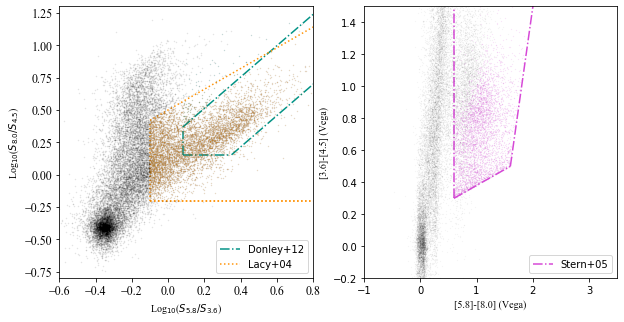

In [6]:
flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'
# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog['zspec'], nan=-99) > 0)
fig, axs = sc.plot_wedge(catalog[never_nan], flux36, flux45, flux58, flux80, selection=['lacy05', 'stern05', 'donley12'])
selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')

In [7]:
print(np.sum(never_nan), np.sum(selected_agn))
ct_lacy = catalog[never_nan][selected_agn]

19816 6014


In [8]:
np.sum(ct_lacy[flux240] > 0) / 6014

1.0

In [9]:
cosmo = af.setup_cosmology()
print('selected_agn:', len(ct_lacy))

ct_lacy = ct_lacy[(ct_lacy['z1_median'] > 0 ) | (ct_lacy['zspec'] > 0)]
# ct_lacy = ct_lacy[ct_lacy['z_eazy'] > 0]
print('selected agn with z:', len(ct_lacy))

# unit conversion: ujansky -> jansky: 1e-6
# jansky -> erg / s / cm**2 / Hz: 1e-23
# erg / s / Hz -> erg / s: nu = c/lambda = 3e8 / 3.6e-6
# unit_conversion = 1e-6 * 1e-23 * 3e8 / 3.6e-6 * (3.086e24)**2
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
# print(unit_conversion)

unbias_photoz = 0.0
# unbias_photoz = 0
z = np.array([row['zspec'] if row['zspec'] > 0 else row['z1_median'] - unbias_photoz for row in ct_lacy])
# z = np.array([row['z1_median'] - unbias_photoz for row in ct_lacy])
print(min(z))
z[z <= 0] = 0
# z = ct_lacy['z_eazy']

spectral_index = np.log10(ct_lacy[flux240].data/ct_lacy[flux58].data) / np.log10(24/5.8)
# spectral_index[spectral_index < -4] = -2
# spectral_index = np.array([0])
print(spectral_index.min(), spectral_index.max())

l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * ct_lacy[flux58].data * unit_conversion * (1 + z)**(-1 + spectral_index)

selected_agn: 6014
selected agn with z: 5914


/usr/local/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


0.0143
-3.4994921686418823 2.9282295326976766


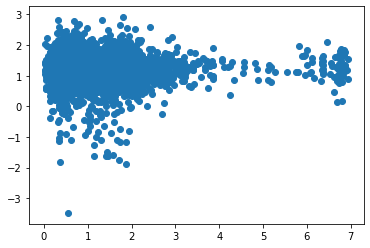

In [10]:
plt.scatter(z, spectral_index)

In [11]:
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42
l_sample_max = 3e46
num_bins_z = 10
num_bins_l = 12

# compare to xray
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42
l_sample_max = 3e46
num_bins_z = 10
num_bins_l = 15



In [12]:
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max)+0.01, num=num_bins_z)
# print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

good_redshift_and_l_selected = (l_sample_min < l) & (l_sample_max > l) & (z_sample_min < z) & (z_sample_max > z)
l = l[good_redshift_and_l_selected]
z = z[good_redshift_and_l_selected]
print(min(l), max(l), min(z), max(z))
# print(len(z))

7.319597645207652e+42 2.507533722453583e+46 0.5001 3.87


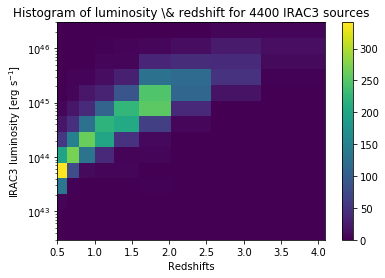

In [13]:

# print(len(z))
fig, ax = vmax.l_z_histo(l, z, l_bins, z_bins, band='IRAC3', unit=r'erg s$^{-1}$')

0.03974999999999995


/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


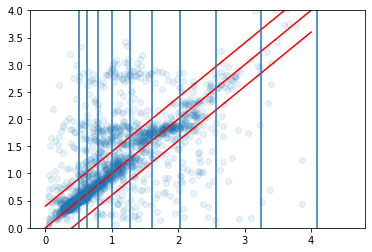

In [14]:
goodzs = (ct_lacy['z1_median'] > 0) & (ct_lacy['zspec'] > 0)
plt.scatter(ct_lacy['zspec'][goodzs], ct_lacy['z1_median'][goodzs], alpha=0.1)
ax = plt.gca()
ax.set_ylim(top=4, bottom=0)
ax.plot([0, 4],[0,4], color='r')
ax.plot([0, 4],[0.4,4.4], color='r')
ax.plot([0, 4],[-.4,3.6], color='r')
for zbin in z_bins:
    ax.axvline(zbin)
bias = np.median(ct_lacy['z1_median'][goodzs] - ct_lacy['zspec'][goodzs])
print(bias)

In [15]:
difs = ct_lacy['z1_median'][goodzs] - ct_lacy['zspec'][goodzs]


In [16]:
i = 2
inbin1 = (ct_lacy['zspec'][goodzs] > z_bins[i]) & (ct_lacy['zspec'][goodzs] < z_bins[i+1])

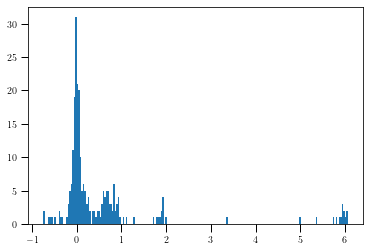

In [34]:
plt.hist(difs[inbin1], bins=200);

In [18]:
# import astropy as ap
# ap.visualization.hist(difs[inbin1], bins=100)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 35.333333  -4.5  
CRPIX : 9450.500101  9850.500106  
NAXIS : 4800  5000


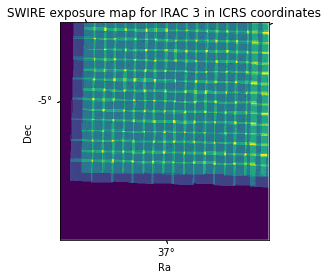

In [19]:
image_file = './data/swire_XMM_I3_tile_1_1_v4_cov.fits'
wcs, hdu = utils.load_wcs(image_file)
fig, ax = vmax.exposure_plot(wcs, hdu.data, survey='SWIRE', band='IRAC 3')

In [20]:
coveragefits = fits.open('./data/XMM-LSS_MOC.fits', memmap=True)
coveragefits[0].header

SIMPLE  =                    T / Written by MOC java API 4.4                    
BITPIX  =                    8                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T                                                  

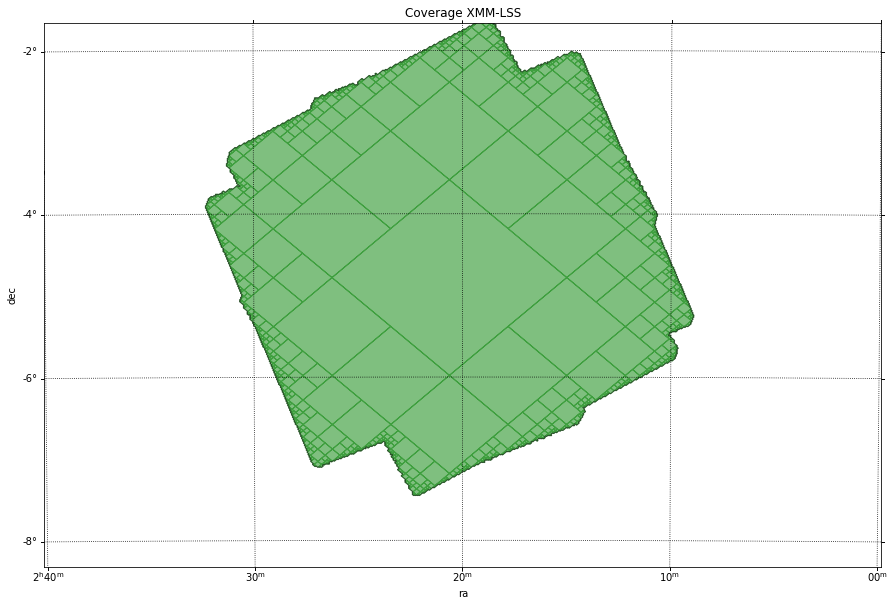

In [21]:
from mocpy import MOC, World2ScreenMPL
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
# Load a MOC
filename = './data/XMM-LSS_MOC.fits'
moc = MOC.from_fits(filename)
# Plot the MOC using matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(111, figsize=(15, 10))
# Define a astropy WCS easily
with World2ScreenMPL(fig, 
        fov=10 * u.deg,
        center=SkyCoord(35, -5, unit='deg', frame='icrs'),
        coordsys="icrs",
        rotation=Angle(0, u.degree),
        projection="AIT") as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="green")
    moc.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_title('Coverage XMM-LSS')
ax.grid(color="black", linestyle="dotted")


In [22]:

flux_limit = 43 * unit_conversion
# flux_limit = 3631 * 10**(23/-2.5) * 5.8e-6 / 3e8
print('computing zmax')
zmax = vmax.compute_zmax(l, z, cosmo, flux_limit, zspacing=0.5, jack_version=False)
zmin = np.array([0]*len(zmax))

# print(zmax)

print('calculating coverage correction')
full_fluxes = catalog[never_nan][flux58]
# print(len(full_fluxes), len(ct_lacy), len(good_redshift_and_l_selected))
coverage_correction = vmax.coverage_correction(ct_lacy[flux58], ct_lacy[flux58][good_redshift_and_l_selected])

# image_file = './data/chen2018-xmmlss-data-products-2018-06-08/xexp_merged.full.v01.fits'
# wcs, hdu = utils.load_wcs(image_file)
# cov_function = vmax.coverage_function(hdu.data, wcs, 3824, 2694, detector_area=36, photon_energy=7e-9)

field_coverage_area = 9.1

def cov_func(l, z): 
    flux = l / (4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2) / unit_conversion
# #     print(flux[0, 0], cov_function(flux[0, 0]))
    return field_coverage_area * coverage_correction(flux)

print('computing vmax vals')
vmax_vals = vmax.compute_binned_vmax_values(l, (z, zmin, zmax), l_bins, z_bins, cosmo, bin_z_bounds=False, coverage=cov_func)

computing zmax
bad zmax inference 215
this is probably due to an issue with the flux limit
zmax/zmin will default to zbin range
calculating coverage correction
computing vmax vals


In [23]:
 coverage_correction(np.logspace(-30, 0, num=50))

array([0.92110209, 0.92110209, 0.92110209, 0.92110209, 0.92110209,
       0.92110209, 0.92110209, 0.92110209, 0.92110209, 0.92110209,
       0.92110209, 0.92110209, 0.92110209, 0.92110209, 0.92110209,
       0.92110209, 0.92110209, 0.92110209, 0.92110209, 0.92110209,
       0.92110209, 0.92110209, 0.92110209, 0.92110209, 0.92110209,
       0.92110209, 0.92110209, 0.92110209, 0.92110209, 0.92110209,
       0.92110209, 0.92110209, 0.92110209, 0.92110209, 0.92110209,
       0.92110209, 0.92110209, 0.92110209, 0.92110209, 0.92110209,
       0.92110207, 0.92110202, 0.92110179, 0.92110087, 0.92109709,
       0.92108162, 0.92101827, 0.92075886, 0.91969659, 0.91534667])

In [24]:
zs = (z_bins[:-1]+z_bins[1:])/2
l_limits = 4 * np.pi * cosmo.luminosity_distance(zs).to(u.cm).value**2 * flux_limit * unit_conversion
print(l_limits)
lf_vals, lf_errs = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins)

[1.58066880e+28 2.78277224e+28 4.92606797e+28 8.74567420e+28
 1.55312411e+29 2.75244272e+29 4.85902012e+29 8.53464253e+29
 1.49055607e+30]


In [25]:
lit_data = {}
hz_convert = 5.8e-6 / 3e8
import importlib
importlib.reload(af)

lacy_ir_evol_params_central = {'A': 10**-4.75, 
                               'gamma1':1.07, 
                               'gamma2':2.48,
                               'Lstar': 10**31.92 / hz_convert,
                               'zref':2.5,
                               'k1':1.05,
                               'k2':-4.71,
                               'k3':-0.034
                              }
lacy_ir_evol_params_max = {'A': 10**-4.73, 
                               'gamma1':1.13, 
                               'gamma2':2.53,
                               'Lstar': 10**31.94 / hz_convert,
                               'zref':2.5,
                               'k1':1.08,
                               'k2':-4.58,
                               'k3':0.156
                              }
lacy_ir_evol_params_min = {'A': 10**-4.77, 
                               'gamma1':1.01, 
                               'gamma2':2.43,
                               'Lstar': 10**31.9 / hz_convert,
                               'zref':2.5,
                               'k1':1.02,
                               'k2':-4.84,
                               'k3':-0.224
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 46.2, num=50)
lacy_mid = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_central)
lacy_high = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_max)
lacy_low = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_min)
# print(lacy_mid[0])
lit_data['Lacy 2015'] = list(zip(lacy_mid, lacy_high, lacy_low))
# lacy_mid[1][:10]

In [26]:
# plot_files = ['./output/lf_91area_specz_kcorrected.npz']#, './output/lf_91area_bothz_unbiased.npz']
# labs = ['specz + k correction']#, 'specz + unbiased photoz']
plot_files = ['./output/lf_xray.npz']
labs = ['xray']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]
    

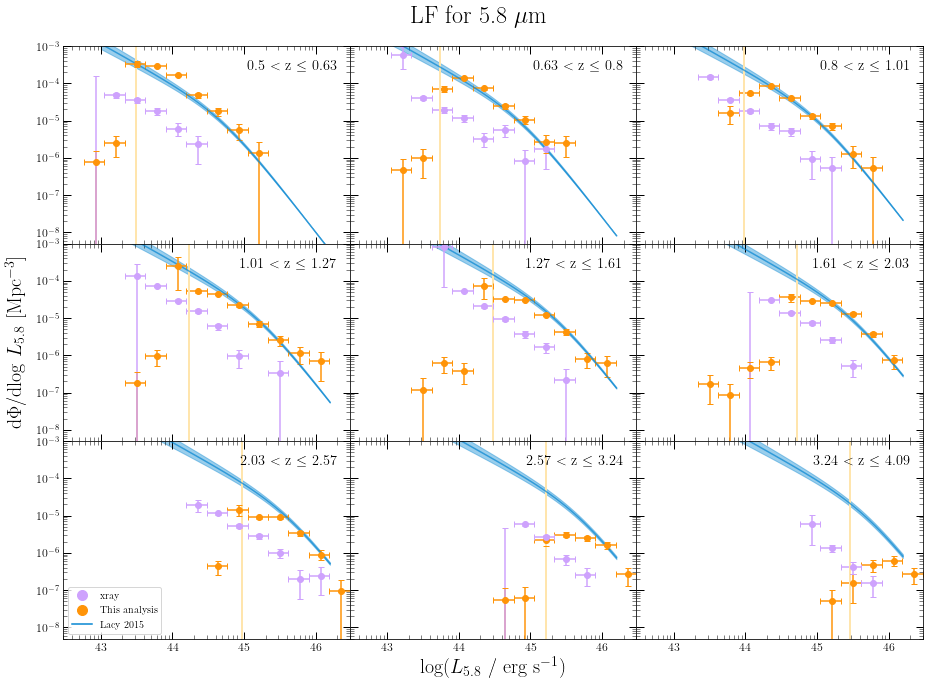

In [33]:
np.savez('./output/lf_91area_bothz_kcorrected.npz', lf_vals=lf_vals, lf_errs=lf_errs)

l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()
fig, axs, big_ax = vmax.plot_lf_vmax(lf_vals, lf_errs, z_bins, l_bins, \
                                     lum_limits=l_limits, compare_to_others=lit_data, \
                                     other_runs=otherruns, title=r'LF for 5.8 $\mu$m', \
                                     outfile='./output/ir_lf.png', lum_sublabel='_{{5.8}}')

In [28]:
vmax_vals[vmax_vals < 0]

array([], dtype=float64)

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


nan


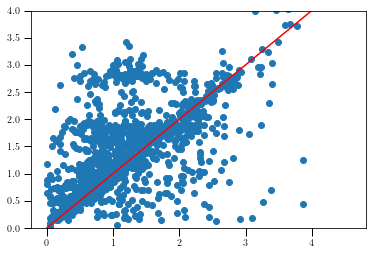

In [29]:
goodzs = (ct_lacy['z1_median'] > 0)
plt.scatter(ct_lacy['zspec'][goodzs], ct_lacy['z1_median'][goodzs])
ax = plt.gca()
ax.set_ylim(top=4, bottom=0)
ax.plot([0, 4],[0,4], color='r')
bias = np.median(ct_lacy['z1_median'][goodzs] - ct_lacy['zspec'][goodzs])
print(bias)

In [30]:
from astropy import cosmology

In [31]:
greene = cosmology.LambdaCDM(H0=71, Om0=0.27, Ode0=0.75)
farrah = cosmology.LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
medling = cosmology.LambdaCDM(H0=70, Om0=0.28, Ode0=0.72)

In [32]:
z=1
farrah.luminosity_distance(z)**2/greene.luminosity_distance(z)**2, farrah.luminosity_distance(z)**2/medling.luminosity_distance(z)**2

(<Quantity 0.98335027>, <Quantity 0.97612978>)